<a href="https://colab.research.google.com/github/MelonChicken/Newsboy/blob/colab/Initial_Newboy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#사이트 크롤링

#데이터 전처리

***KoNLPy를 사용하여 한글로 된 글을 적절하게 말뭉치로 바꾼다***

In [10]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

!pip install --target=$nb_path konlpy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached konlpy-0.6.0-py2.py3-none-any.whl (19.4 MB)
  Using cached JPype1-1.4.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (465 kB)
  Using cached lxml-4.9.3-cp310-cp310-manylinux_2_28_x86_64.whl (7.9 MB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached packaging-23.2-py3-none-any.whl (53 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompat

한글 깨짐 방지를 위해 나눔폰트 설치

관련 링크(https://teddylee777.github.io/colab/colab-korean/)

In [26]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (24.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120899 files and direc

In [11]:
import konlpy
from konlpy.tag import Okt, Hannanum, Kkma

text = "아버지가방에들어가신다."
#다음 세개의 함수는 KoNLPy 내 분석기이다. 이외에도 Komoran, Mecab등이 있는데, 현재 품질이 가장 좋은 것은 Mecab이다.

okt = Okt() #Open Korea Text
hannanum = Hannanum() #한나눔 Hannanum
kkma = Kkma()  #꼬꼬마 KKma
print("okt 형태소 추출:", okt.morphs(text))
print("Hannanum 형태소 추출:", hannanum.morphs(text))
print("Kkma 형태소 추출:", kkma.morphs(text))

print("okt 명사 추출:", okt.nouns(text))
print("Hannanum 명사 추출:", hannanum.nouns(text))
print("Kkma 명사 추출:", kkma.nouns(text))

okt 형태소 추출: ['아버지', '가방', '에', '들어가신다', '.']
Hannanum 형태소 추출: []
Kkma 형태소 추출: ['아버지', '가방', '에', '들어가', '시', 'ㄴ다', '.']
okt 명사 추출: ['아버지', '가방']
Hannanum 명사 추출: []
Kkma 명사 추출: ['아버지', '아버지가방', '가방']


corpus : 단어들을 저장하기 위해서 만든 리스트로, 문장형태의 샘플을 단어로 변환, 저장한다.

word_to_id : key = word, value = id

id_to_word : key = id, value = word

In [1]:
import numpy as np

def preprocess(text):

    text = text.lower() ##영어인 경우 상정
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

***단어를 이용해서 동시발생행렬을 짠다***

In [2]:
def create_co_matrix(corpus, vocab_size, window_size=1): #동시발생행렬을 자동으로 만들기 위한 함수
                                                         #vocab_size는 word_to_id의 length를 구하면 된다. 다시말해 단어의 개수를 입력하는 파라미터이다.
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32) ##co_matrix 초기화

    for idx, word_id in enumerate(corpus): #주변단어를 세고 이를 co_matrix에 저장한다. (one-hot vector가 아님을 유념하자)
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx>=0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] +=1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

***벡터간 유사도 계산을 이용해서 단어 의미의 유사도를 계산한다.***

In [3]:
def cos_similarity(x, y, eps = 1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps) #각 벡터의 norm을 계산한다.
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return(np.dot(nx, ny))

In [4]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    #검색어를 꺼낸다
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] '+query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    #코사인 유사도를 계산한다.
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    #코사인 유사도를 기준으로 내림차순으로 출력한다.

    count = 0
    for i in (-1*similarity).argsort(): #argsort()는 넘파이 배열의 원소를 오름차순으로 정렬하며, 이때의 반환값은 배열의 "인덱스"이다.
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count +=1
        if count>=top:
            return

***점별 상호량을 통해 단어간 관련성을 구한다.***

In [5]:
def ppmi (C, verbose=False, eps=1e-8):
    #C는 동시발생 행렬이고, verbose는 진행상황 출력 여부를 결정하는 플래그이다.
    M = np.zeros_like(C, dtype=np.float32) #동시발생행렬의 크기와 동일한 크기의 행렬을 만든다.
    print(f'M = {M}\n')

    N = np.sum(C)
    print(f'N = {N}\n')

    S = np.sum(C, axis=0)
    print(f'S = {S}\n')

    total = C.shape[0] * C.shape[1]
    print(f'total = {total}')

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j]*N/(S[j]*S[i])+eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt+=1
                if cnt%(total//100+1) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))

    return M

#키워드 통계 분석

게시물을 어떻게 저장할 것인가? -> 관계형 데이터베이스 형태가 무난할 것 으로 생각.


****<고유 id, 작성자, 조회수, 좋아요수, 주요 키워드, 접근 url>****

#예시 데이터 생성

In [ ]:
import random
from datetime import date

In [ ]:
class Post():
    id = 'YYMMDD-###'
    user = ''
    view = 0
    likes = 0
    contents = 'This is the whole sentence of the single post.'
    keywords = []
    url = 'https://www.google.com'

In [ ]:
def MakeID(PostList, num):
    for i in range(num):

        now = date.today()

        if now.month <= 9:
            month = '0' + str(now.month)
        else:
            month = now.month

        if now.day <= 9:
            day = '0' + str(now.day)
        else:
            day = now.day

        if i+1<10:
            cnt = '00'+str(i+1)
        elif i+1<100:
            cnt = '0'+str(i+1)
        else:
            cnt=i+1

        tmp_post = Post()
        tmp_post.id = f'{str(now.year)[2:]}{month}{day}-{cnt}'
        PostList.append(tmp_post)

    return PostList

In [ ]:
def MakeUserName(PostList):
    colors = ['초록빛깔', '파란', '노란', '까만', '황금빛깔', '다홍빛깔', '하얀']
    animals = ['악어', '펭귄', '부엉이', '올빼미', '곰', '돼지', '소', '닭', '독수리', '타조', '고릴라', '오랑우탄', '침팬지', '원숭이', '코알라', '캥거루', '고래', '상어', '칠면조', '직박구리', '쥐', '청설모', '메추라기', '앵무새', '삵', '스라소니', '판다', '오소리', '오리', '거위', '백조', '두루미', '고슴도치', '두더지', '우파루파', '맹꽁이', '너구리', '개구리', '두꺼비', '카멜레온', '이구아나', '노루', '제비', '까치', '고라니', '수달', '당나귀', '순록', '염소', '공작', '바다표범', '들소', '박쥐', '참새', '물개', '바다사자', '살모사', '구렁이', '얼룩말', '산양', '멧돼지', '카피바라', '바다코끼리', '도롱뇽', '북극곰', '퓨마', '미어캣', '코요테', '라마', '딱따구리', '기러기', '비둘기', '스컹크', '아르마딜로', '돌고래', '까마귀', '매', '낙타', '여우', '사슴', '늑대', '재규어', '알파카', '양', '다람쥐', '담비']

    for i in range(len(PostList)):
        PostList[i].user = f'{colors[random.randint(1, len(colors)-1)]} {animals[random.randint(1, len(animals)-1)]}'

    return PostList

In [ ]:
def PutOtherInfo(PostList):
    for post in PostList:

        post.view = random.randint(1, 10000) #조회수
        post.likes = random.randint(1, 100) #좋아요수
    return PostList

In [ ]:
sample = PutOtherInfo(MakeUserName(MakeID([], 20)))

NameError: ignored

In [ ]:
cnt = 1
for post in sample:
    print(f'---{cnt}번 샘플 데이터---')
    print(f'ID : {post.id}')
    print(f'user : {post.user}')
    print(f'view : {post.view}')
    print(f'likes : {post.likes}')
    print(f'keywords : {post.keywords}')
    print(f'url : {post.url}')
    print('-'*10 + '\n\n')

    cnt+=1


---1번 샘플 데이터---
ID : 231207-001
user : 하얀 카피바라
view : 9740
likes : 10
keywords : []
url : https://www.google.com
----------


---2번 샘플 데이터---
ID : 231207-002
user : 황금빛깔 비둘기
view : 1581
likes : 39
keywords : []
url : https://www.google.com
----------


---3번 샘플 데이터---
ID : 231207-003
user : 다홍빛깔 이구아나
view : 4803
likes : 38
keywords : []
url : https://www.google.com
----------


---4번 샘플 데이터---
ID : 231207-004
user : 하얀 이구아나
view : 3091
likes : 15
keywords : []
url : https://www.google.com
----------


---5번 샘플 데이터---
ID : 231207-005
user : 황금빛깔 북극곰
view : 4726
likes : 16
keywords : []
url : https://www.google.com
----------


---6번 샘플 데이터---
ID : 231207-006
user : 까만 오소리
view : 8592
likes : 50
keywords : []
url : https://www.google.com
----------


---7번 샘플 데이터---
ID : 231207-007
user : 노란 직박구리
view : 1919
likes : 87
keywords : []
url : https://www.google.com
----------


---8번 샘플 데이터---
ID : 231207-008
user : 파란 양
view : 61
likes : 42
keywords : []
url : https://www.google.com
-------

In [ ]:
cnt = 1
#조회수 순으로 게시물 정렬
for post in sorted(sample, key = lambda x: x.view, reverse= True):
    print(f'---좋아요순 정렬---')
    print(f'ID : {post.id}')
    print(f'user : {post.user}')
    print(f'view : {post.view}')
    print(f'likes : {post.likes}')
    print(f'keywords : {post.keywords}')
    print('-'*10 + '\n\n')

    cnt+=1


---좋아요순 정렬---
ID : 231207-011
user : 노란 수달
view : 9924
likes : 83
keywords : []
----------


---좋아요순 정렬---
ID : 231207-001
user : 하얀 카피바라
view : 9740
likes : 10
keywords : []
----------


---좋아요순 정렬---
ID : 231207-006
user : 까만 오소리
view : 8592
likes : 50
keywords : []
----------


---좋아요순 정렬---
ID : 231207-018
user : 하얀 염소
view : 7957
likes : 7
keywords : []
----------


---좋아요순 정렬---
ID : 231207-014
user : 황금빛깔 도롱뇽
view : 7432
likes : 36
keywords : []
----------


---좋아요순 정렬---
ID : 231207-013
user : 노란 코요테
view : 6841
likes : 71
keywords : []
----------


---좋아요순 정렬---
ID : 231207-012
user : 노란 이구아나
view : 6222
likes : 74
keywords : []
----------


---좋아요순 정렬---
ID : 231207-019
user : 황금빛깔 기러기
view : 4904
likes : 31
keywords : []
----------


---좋아요순 정렬---
ID : 231207-003
user : 다홍빛깔 이구아나
view : 4803
likes : 38
keywords : []
----------


---좋아요순 정렬---
ID : 231207-009
user : 파란 물개
view : 4737
likes : 14
keywords : []
----------


---좋아요순 정렬---
ID : 231207-005
user : 황금빛깔 북극곰
view : 47

In [ ]:
cnt = 1
#좋아요수 순으로 게시물 정렬
for post in sorted(sample, key = lambda x: x.likes, reverse= True):
    print(f'---{cnt}번 샘플 데이터---')
    print(f'ID : {post.id}')
    print(f'user : {post.user}')
    print(f'view : {post.view}')
    print(f'likes : {post.likes}')
    print(f'keywords : {post.keywords}')
    print('-'*10 + '\n\n')

    cnt+=1


---1번 샘플 데이터---
ID : 231207-017
user : 하얀 바다코끼리
view : 1650
likes : 97
keywords : []
----------


---2번 샘플 데이터---
ID : 231207-007
user : 노란 직박구리
view : 1919
likes : 87
keywords : []
----------


---3번 샘플 데이터---
ID : 231207-011
user : 노란 수달
view : 9924
likes : 83
keywords : []
----------


---4번 샘플 데이터---
ID : 231207-020
user : 까만 코알라
view : 2326
likes : 76
keywords : []
----------


---5번 샘플 데이터---
ID : 231207-016
user : 파란 이구아나
view : 483
likes : 75
keywords : []
----------


---6번 샘플 데이터---
ID : 231207-012
user : 노란 이구아나
view : 6222
likes : 74
keywords : []
----------


---7번 샘플 데이터---
ID : 231207-013
user : 노란 코요테
view : 6841
likes : 71
keywords : []
----------


---8번 샘플 데이터---
ID : 231207-006
user : 까만 오소리
view : 8592
likes : 50
keywords : []
----------


---9번 샘플 데이터---
ID : 231207-008
user : 파란 양
view : 61
likes : 42
keywords : []
----------


---10번 샘플 데이터---
ID : 231207-002
user : 황금빛깔 비둘기
view : 1581
likes : 39
keywords : []
----------


---11번 샘플 데이터---
ID : 231207-003
user 

###Pandas의 방식으로 가공하기

In [ ]:
import pandas as pd

DataFrame.loc[_indexName] = [] : index를 지정해서 행을 추가하는 방법이다. 이때 맨 - 마지막에 None을 추가하면 값이 없는 경우 자동으로 None을 통해 빈 데이터를 채운다.
- 이미 있는 Index Name에 지정
- 단 순서는 항상 맨 마지막에 추가된다.


In [ ]:
#먼저 각 column Name만 지정된 빈 데이터 프레임을 형성한다.
dataFrame_empty = pd.DataFrame(columns = ['ID', 'USER NAME', 'VIEW', 'LIKES', 'CONTENTS', 'KEYWORDS', 'URL']) #열은 columns로 지정, 행은 index로 지정 (dtypes should be LIST)

#dataFrame_empty.info #정보 확인
print(dataFrame_empty)
#저장하고자 하는 데이터를 넣는 작업 (조회수를 기준으로 정렬할 것임.)
cnt = 1
for post in sorted(sample, key = lambda x: x.view, reverse = True):
    dataFrame_empty.loc[cnt] = [post.id, post.user, post.view, post.likes, post.contents, post.keywords, post.url]
    cnt+=1

    if cnt == len(sample):
        dataFrame_result = dataFrame_empty


print(dataFrame_result)




Empty DataFrame
Columns: [ID, USER NAME, VIEW, LIKES, CONTENTS, KEYWORDS, URL]
Index: []
            ID  USER NAME  VIEW  LIKES  \
1   231207-011      노란 수달  9924     83   
2   231207-001    하얀 카피바라  9740     10   
3   231207-006     까만 오소리  8592     50   
4   231207-018      하얀 염소  7957      7   
5   231207-014   황금빛깔 도롱뇽  7432     36   
6   231207-013     노란 코요테  6841     71   
7   231207-012    노란 이구아나  6222     74   
8   231207-019   황금빛깔 기러기  4904     31   
9   231207-003  다홍빛깔 이구아나  4803     38   
10  231207-009      파란 물개  4737     14   
11  231207-005   황금빛깔 북극곰  4726     16   
12  231207-010   하얀 아르마딜로  4508      5   
13  231207-004    하얀 이구아나  3091     15   
14  231207-020     까만 코알라  2326     76   
15  231207-007    노란 직박구리  1919     87   
16  231207-015     노란 알파카  1896      3   
17  231207-017   하얀 바다코끼리  1650     97   
18  231207-002   황금빛깔 비둘기  1581     39   
19  231207-016    파란 이구아나   483     75   
20  231207-008       파란 양    61     42   

                            

### Google Colab System 설정

In [ ]:
import openpyxl

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

MessageError: ignored

###엑셀 접근

In [ ]:
wb = openpyxl.Workbook() #Workbook 생성

wb.active.title = 'Title' #자동으로 만들어지는 첫번째 sheet 제목 생성
#wb.create_sheet("TITLE") #새로 만드는 sheet 이름 지정
new_fileName = f'{nb_path}/Toy-Project/Newsboy/NewsboyData.xlsx'

target_excel = wb['Title']
target_excel.cell(2, 1).value = "Test" #cell(행Num, 열Alp)

wb.save(new_fileName) #지정한 경로에 파일 저장


###---

In [ ]:
wb = openpyxl.Workbook(f'{nb_path}/Toy-Project/Newsboy/NewsboyData.xlsx') #Workbook 생성

wb.create_sheet = '{: %y%m%d}'.format(date.today())
target_excel = wb['{: %y%m%d}'.format(date.today())]

for i in range(20): #Temporary
    tmp_post = sample[i]
    tmp_post_list = [tmp_post.id, tmp_post.user, tmp_post.view, tmp_post.likes, tmp_post.keywords, tmp_post.url]
    for j in range(6):
        target_excel.cell(i, j).value = tmp_post_list[j]

wb.save(new_fileName) #지정한 경로에 파일 저장

#샘플 테스트

##샘플 글의 단어를 통계처리해보자.

####샘플

용서는 곧 사랑이다. 고결하고 아름다운 사랑의 형태이다. 사랑이 없는 사람은 쉽게 용서하지 못한다. 용서는 평화와 행복을 그 보답으로 준다. 그대, 용서함으로써 행복 하라! 용감한 자만이 용서할 줄 알고 비겁한 자는 용서하지 않는다. 용서는 남에게는 자주 베풀지만 자신에게는 베풀지 마라. 누군가가 당신에게 피해를 입혔다면 인내심을 가지고 그들을 대하라. 부드러운 말은 상처를 소독한다. 용서는 상처를 치유하고, 망각은 흉터를 지운다. 상처를 낫게 하려고 논쟁을 벌이는 것보다 조용히 상처를 기다리는 편이 더 낫다. 용서가 신성하듯이 극도의 어려움을 참고 견디는 것은 훌륭하다. 용서하는 것은 아름답다.용서하지 않으면 분노를 되새김질하게 되고 과거의 기억과 상처에 매달리게 되면서 자기 자신의 노예가 되는 것이다. 상처에 집착하는 것은 자기 자신을 불행하게 만든다. 용서는 자신을 위해 상처를 떨쳐버리는 것이다. 상처의 진정한 치유는 용서에서 온다. 용서는 자신 안에 갇힌 에너지를 밖으로 내보내 세상에서 선한 일을 하는데 쓸 수 있게 한다. 용서는 삶 속에서 실천할 수 있는 큰 수행이다. 용서할 때는 마음에 문을 열 수 있다. 용서하는 마음은 상처 준 이들을 받아들이는 마음이다. 진정한 용서는 마음의 쇠사슬에 묶여 있던 이들을 위안해주고 안심시켜 주는 일이다. 자신을 멍들게 하고 파괴시킨 미움과 원망의 마음에서 스스로 벗어나는 일이다. 그대를 고통스럽게 만든 사람에게 나쁜 감정을 키워나가면 그대 자신의 마음의 평화만 깨어질 뿐이다. 그대가 그를 용서한다면, 그대 마음은 평온을 되찾을 것이다. 누군가를 용서한다는 것은 알고 보면 자신을 위한 것이다. 타인을 용서치 못하면 스스로 건너야 하는 다리를 부스는 것이나 마찬가지다. 죄를 저지를 자와 피해를 입은 자, 모두에게 용서가 필요한 법이다. 약자는 결코 용서할 수가 없다. 용서는 강자의 속성이다. 증오는 사랑만이 극복할 수 있다. 용서할 수는 있어도 잊을 수는 없다고 하는 말은 용서할 수 없다는 말이다. 잊어버리는 것이 용서해주는 것이다. 결혼은 30%의 사랑과 70%의 용서이다. 남을 꾸짖는 마음으로 자신을 꾸짖고 자신을 용서하는 마음으로 남을 용서하라. 대장부는 남을 용서해야 마땅하지만 남의 용서를 받는 사람이 되어서는 안 된다. 다른 사람을 용서하되, 자신은 용서하지 마라.

####코드

용서는 곧 사랑이다. 고결하고 아름다운 사랑의 형태이다. 사랑이 없는 사람은 쉽게 용서하지 못한다. 용서는 평화와 행복을 그 보답으로 준다. 그대, 용서함으로써 행복 하라! 용감한 자만이 용서할 줄 알고 비겁한 자는 용서하지 않는다. 용서는 남에게는 자주 베풀지만 자신에게는 베풀지 마라. 누군가가 당신에게 피해를 입혔다면 인내심을 가지고 그들을 대하라. 부드러운 말은 상처를 소독한다. 용서는 상처를 치유하고, 망각은 흉터를 지운다. 상처를 낫게 하려고 논쟁을 벌이는 것보다 조용히 상처를 기다리는 편이 더 낫다. 용서가 신성하듯이 극도의 어려움을 참고 견디는 것은 훌륭하다. 용서하는 것은 아름답다.용서하지 않으면 분노를 되새김질하게 되고 과거의 기억과 상처에 매달리게 되면서 자기 자신의 노예가 되는 것이다. 상처에 집착하는 것은 자기 자신을 불행하게 만든다. 용서는 자신을 위해 상처를 떨쳐버리는 것이다. 상처의 진정한 치유는 용서에서 온다. 용서는 자신 안에 갇힌 에너지를 밖으로 내보내 세상에서 선한 일을 하는데 쓸 수 있게 한다. 용서는 삶 속에서 실천할 수 있는 큰 수행이다. 용서할 때는 마음에 문을 열 수 있다. 용서하는 마음은 상처 준 이들을 받아들이는 마음이다. 진정한 용서는 마음의 쇠사슬에 묶여 있던 이들을 위안해주고 안심시켜 주는 일이다. 자신을 멍들게 하고 파괴시킨 미움과 원망의 마음에서 스스로 벗어나는 일이다. 그대를 고통스럽게 만든 사람에게 나쁜 감정을 키워나가면 그대 자신의 마음의 평화만 깨어질 뿐이다. 그대가 그를 용서한다면, 그대 마음은 평온을 되찾을 것이다. 누군가를 용서한다는 것은 알고 보면 자신을 위한 것이다. 타인을 용서치 못하면 스스로 건너야 하는 다리를 부스는 것이나 마찬가지다. 죄를 저지를 자와 피해를 입은 자, 모두에게 용서가 필요한 법이다. 약자는 결코 용서할 수가 없다. 용서는 강자의 속성이다. 증오는 사랑만이 극복할 수 있다. 용서할 수는 있어도 잊을 수는 없다고 하는 말은 용서할 수 없다는 말이다. 잊어버리는 것이 용서해주는 것이다. 결혼은 30%의 사랑과 70%의 용서이다. 남을 꾸짖는 마음으로 자신을 꾸짖고 자신을 용서하는 마음으로 남을 용서하라. 대장부는 남을 용서해야 마땅하지만 남의 용서를 받는 사람이 되어서는 안 된다. 다른 사람을 용서하되, 자신은 용서하지 마라

House and Senate negotiators released their compromise draft of an annual defense policy bill Thursday, which calls for maintaining 28,500 U.S. troops in South Korea and deepening nuclear deterrence coordination between Seoul and Washington. They unveiled the final draft of the National Defense Authorization Act (NDAA) for the 2024 fiscal year. Congress passes the bill each year to set defense policy and funding priorities and give guidance on a range of key security matters. The NDAA draft includes a call to reinforce the South Korea-U.S. alliance by maintaining the U.S. troop presence in South Korea at its current level and affirming the U.S. extended deterrence commitment to using the full range of its defense capabilities. It also calls for deeper coordination on nuclear deterrence as highlighted in the Washington Declaration that South Korean President Yoon Suk Yeol and U.S. President Joe Biden adopted during their White House summit in April. The declaration entailed the creation of the Nuclear Consultative Group designed to discuss nuclear and strategic planning issues, and other measures to enhance the credibility of America's extended deterrence commitment to South Korea. The mention of the declaration was not included in the initial Senate NDAA bill though it was in the House draft. On the allies' efforts for the conditions-based transition of wartime operational control (OPCON), the bill requests that the secretary of defense in coordination with the secretary of state submit to relevant congressional committees a report on a set of transfer conditions no later than 180 days after the act's enactment. The draft also stipulates that no later than 45 days before the transfer, the defense secretary is to notify Congress of such a transfer. The draft increases the national defense budget by roughly 3 percent to US$886 billion. Providing for our national defense is Congress' most important responsibility under the U.S. Constitution, and the NDAA is key to fulfilling that duty. Our nation faces unprecedented threats from China, Iran, Russia, and North Korea, representatives of the House and Senate Armed Services Committees said in a statement. We urge Congress to pass the NDAA quickly and President Biden to sign it when it reaches his desk, they added. After the House and Senate endorsed their respective NDAA versions in July, their negotiators carried out intense negotiations to craft a bipartisan version, which should then be passed by both chambers


In [12]:
import konlpy
from konlpy.tag import Okt

okt = Okt()

def preprocessKOR(text):

    words = okt.nouns(text)
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [13]:
import konlpy
from konlpy.tag import Okt, Hannanum, Kkma

sample_text01 = "용서는 곧 사랑이다. 고결하고 아름다운 사랑의 형태이다. 사랑이 없는 사람은 쉽게 용서하지 못한다. 용서는 평화와 행복을 그 보답으로 준다. 그대, 용서함으로써 행복 하라! 용감한 자만이 용서할 줄 알고 비겁한 자는 용서하지 않는다. 용서는 남에게는 자주 베풀지만 자신에게는 베풀지 마라. 누군가가 당신에게 피해를 입혔다면 인내심을 가지고 그들을 대하라. 부드러운 말은 상처를 소독한다. 용서는 상처를 치유하고, 망각은 흉터를 지운다. 상처를 낫게 하려고 논쟁을 벌이는 것보다 조용히 상처를 기다리는 편이 더 낫다. 용서가 신성하듯이 극도의 어려움을 참고 견디는 것은 훌륭하다. 용서하는 것은 아름답다.용서하지 않으면 분노를 되새김질하게 되고 과거의 기억과 상처에 매달리게 되면서 자기 자신의 노예가 되는 것이다. 상처에 집착하는 것은 자기 자신을 불행하게 만든다. 용서는 자신을 위해 상처를 떨쳐버리는 것이다. 상처의 진정한 치유는 용서에서 온다. 용서는 자신 안에 갇힌 에너지를 밖으로 내보내 세상에서 선한 일을 하는데 쓸 수 있게 한다. 용서는 삶 속에서 실천할 수 있는 큰 수행이다. 용서할 때는 마음에 문을 열 수 있다. 용서하는 마음은 상처 준 이들을 받아들이는 마음이다. 진정한 용서는 마음의 쇠사슬에 묶여 있던 이들을 위안해주고 안심시켜 주는 일이다. 자신을 멍들게 하고 파괴시킨 미움과 원망의 마음에서 스스로 벗어나는 일이다. 그대를 고통스럽게 만든 사람에게 나쁜 감정을 키워나가면 그대 자신의 마음의 평화만 깨어질 뿐이다. 그대가 그를 용서한다면, 그대 마음은 평온을 되찾을 것이다. 누군가를 용서한다는 것은 알고 보면 자신을 위한 것이다. 타인을 용서치 못하면 스스로 건너야 하는 다리를 부스는 것이나 마찬가지다. 죄를 저지를 자와 피해를 입은 자, 모두에게 용서가 필요한 법이다. 약자는 결코 용서할 수가 없다. 용서는 강자의 속성이다. 증오는 사랑만이 극복할 수 있다. 용서할 수는 있어도 잊을 수는 없다고 하는 말은 용서할 수 없다는 말이다. 잊어버리는 것이 용서해주는 것이다. 결혼은 30%의 사랑과 70%의 용서이다. 남을 꾸짖는 마음으로 자신을 꾸짖고 자신을 용서하는 마음으로 남을 용서하라. 대장부는 남을 용서해야 마땅하지만 남의 용서를 받는 사람이 되어서는 안 된다. 다른 사람을 용서하되, 자신은 용서하지 마라"
#다음 세개의 함수는 KoNLPy 내 분석기이다. 이외에도 Komoran, Mecab등이 있는데, 현재 품질이 가장 좋은 것은 Mecab이다.

okt = Okt() #Open Korea Text

print("okt 명사 추출:", okt.nouns(sample_text01))

corpus, word_to_id, id_to_word = preprocessKOR(sample_text01)

vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('그대', word_to_id, id_to_word, C, top=5)

okt 명사 추출: ['용서', '곧', '사랑', '사랑', '형태', '사랑', '사람', '용서', '용서', '평화', '행복', '그', '보답', '그대', '용서', '함', '행복', '하라', '자만', '용서', '줄', '알', '용서', '용서', '남', '자주', '자신', '누군가', '당신', '피해', '인내심', '가지', '그', '대하', '말', '상처', '소독', '용서', '상처', '치유', '망각', '흉터', '상처', '낫', '논쟁', '것', '상처', '편이', '더', '낫다', '용서', '극도', '어려움', '참고', '것', '용서', '것', '용서', '분노', '되새김질', '과거', '기억', '상처', '자기', '자신', '노예', '것', '상처', '집착', '것', '자기', '자신', '용서', '자신', '위해', '상처', '것', '상처', '치유', '용서', '용서', '자신', '안', '에너지', '밖', '세상', '일', '수', '용서', '삶', '속', '실천', '수', '수행', '용서', '때', '마음', '문', '열', '수', '용서', '마음', '상처', '준', '이', '마음', '용서', '마음', '쇠사슬', '이', '위안', '안심', '일이', '자신', '멍', '파괴', '미움', '원망', '마음', '스스로', '일이', '그대', '고통', '사람', '감정', '그대', '자신', '마음', '평화', '뿐', '그대', '그', '용서', '그대', '마음', '평온', '것', '누군가', '용서', '것', '알', '자신', '위', '것', '타인', '용서', '치', '스스로', '다리', '부스', '것', '마찬가지', '죄', '자', '피해', '자', '모두', '용서', '법', '약자', '결코', '용서', '수가', '용서', '강', '속성', '증오', '사랑', '극복', '수', '용

In [13]:
sample_text = "House and Senate negotiators released their compromise draft of an annual defense policy bill Thursday, which calls for maintaining 28,500 U.S. troops in South Korea and deepening nuclear deterrence coordination between Seoul and Washington. They unveiled the final draft of the National Defense Authorization Act (NDAA) for the 2024 fiscal year. Congress passes the bill each year to set defense policy and funding priorities and give guidance on a range of key security matters. The NDAA draft includes a call to reinforce the South Korea-U.S. alliance by maintaining the U.S. troop presence in South Korea at its current level and affirming the U.S. extended deterrence commitment to using the full range of its defense capabilities. It also calls for deeper coordination on nuclear deterrence as highlighted in the Washington Declaration that South Korean President Yoon Suk Yeol and U.S. President Joe Biden adopted during their White House summit in April. The declaration entailed the creation of the Nuclear Consultative Group designed to discuss nuclear and strategic planning issues, and other measures to enhance the credibility of America's extended deterrence commitment to South Korea. The mention of the declaration was not included in the initial Senate NDAA bill though it was in the House draft. On the allies' efforts for the conditions-based transition of wartime operational control (OPCON), the bill requests that the secretary of defense in coordination with the secretary of state submit to relevant congressional committees a report on a set of transfer conditions no later than 180 days after the act's enactment. The draft also stipulates that no later than 45 days before the transfer, the defense secretary is to notify Congress of such a transfer. The draft increases the national defense budget by roughly 3 percent to US$886 billion. Providing for our national defense is Congress' most important responsibility under the U.S. Constitution, and the NDAA is key to fulfilling that duty. Our nation faces unprecedented threats from China, Iran, Russia, and North Korea, representatives of the House and Senate Armed Services Committees said in a statement. We urge Congress to pass the NDAA quickly and President Biden to sign it when it reaches his desk, they added. After the House and Senate endorsed their respective NDAA versions in July, their negotiators carried out intense negotiations to craft a bipartisan version, which should then be passed by both chambers."

corpus, word_to_id, id_to_word = preprocess(sample_text)

corpus, word_to_id, id_to_word = preprocess(sample_text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('their', word_to_id, id_to_word, C, top=5)


[query] their
 released: 0.24999999734834955
 carried: 0.24999999734834955
 adopted: 0.24999999734834955
 senate: 0.18898223533138422
 negotiators: 0.1767766937877534


In [14]:
statistics_wordID = {}

cnt = 0
for id in sorted(corpus):

    if cnt == 0:
        tmp_word = id_to_word[id]

    elif tmp_word == id_to_word[id]:

        if not tmp_word in statistics_wordID.keys():
            statistics_wordID[tmp_word] = 2

        else:
            statistics_wordID[tmp_word] +=1

    else:
        tmp_word = id_to_word[id]

    cnt+=1

sorted_list = sorted(statistics_wordID, key = lambda x: statistics_wordID[x], reverse = True)

for item in sorted_list:
    print(item, " : ", statistics_wordID[item])

용서  :  34
것  :  12
자신  :  11
상처  :  9
마음  :  9
수  :  7
사랑  :  5
그대  :  5
남  :  5
사람  :  4
그  :  3
말  :  3
평화  :  2
행복  :  2
알  :  2
누군가  :  2
피해  :  2
치유  :  2
자기  :  2
안  :  2
이  :  2
일이  :  2
스스로  :  2
자  :  2
의  :  2


In [15]:
import matplotlib.pyplot as plt

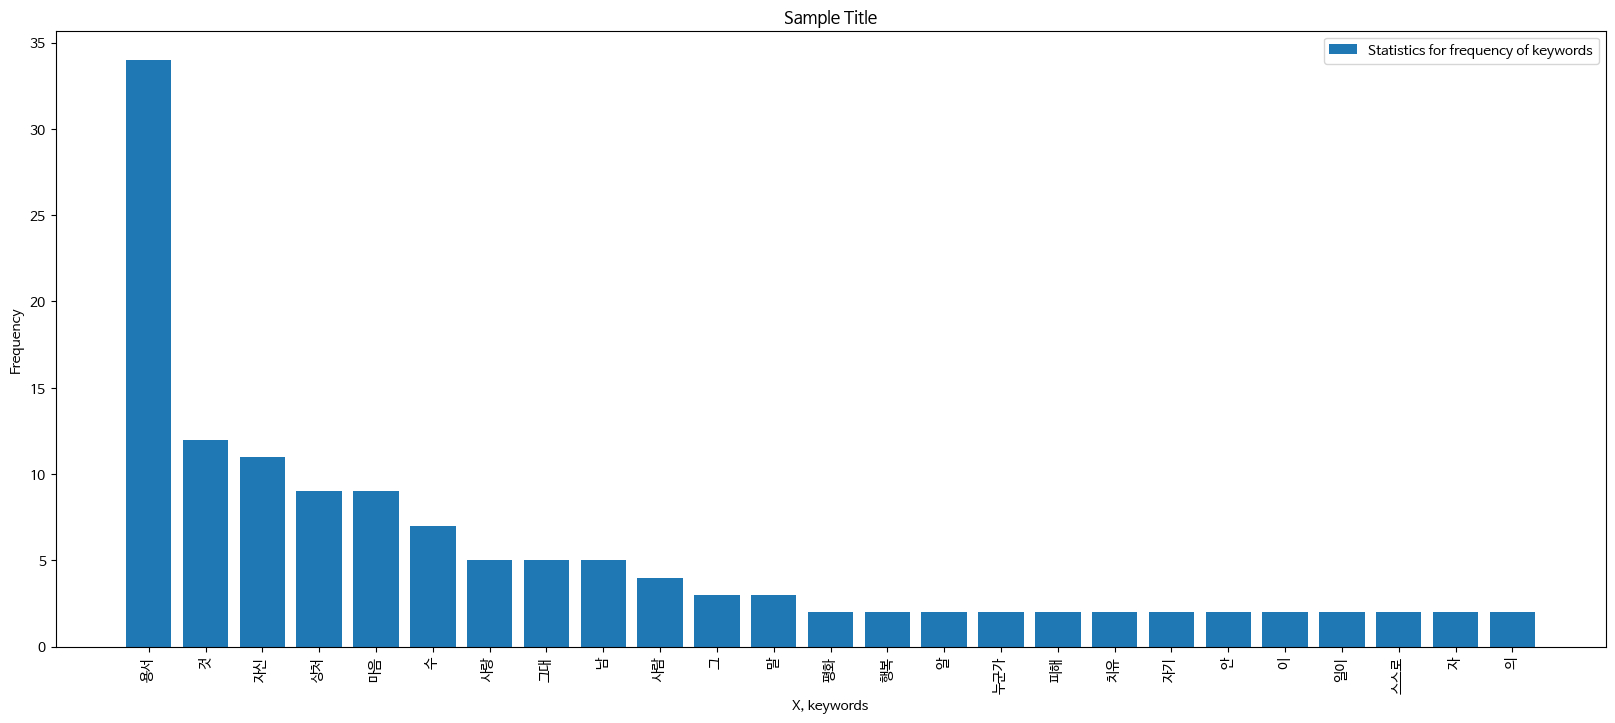

In [17]:
x=np.array(sorted_list)
y=np.array([statistics_wordID[item] for item in sorted_list])

plt.figure(figsize=(20,8)) #단위는 inch
plt.rc('font', family='NanumBarunGothic')

plt.bar(x,y,label="Statistics for frequency of keywords")
plt.xlabel("X, keywords")
plt.xticks(rotation=90)
plt.ylabel("Frequency")

plt.title('Sample Title')
plt.legend()
plt.show()